In [18]:


# ===========================
#  Imports & Setup
# ===========================
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, f1_score, accuracy_score)

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

In [2]:
RS = 42

In [3]:
# ===========================
# Load Preprocessed Data
# ===========================
df_encoded = pd.read_csv("./../data/df_encoded.csv")
print("Shape:", df_encoded.shape)

X = df_encoded.drop("default_pnm", axis=1)
y = df_encoded["default_pnm"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RS, stratify=y
)

print("Class balance (train):")
print(y_train.value_counts(normalize=True))

Shape: (30000, 30)
Class balance (train):
default_pnm
0    0.778792
1    0.221208
Name: proportion, dtype: float64


In [4]:
X.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2', 'MARRIAGE_1',
       'MARRIAGE_2', 'MARRIAGE_3', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4'],
      dtype='object')

In [23]:
# ===========================
#  Helper Functions
# ===========================
def evaluate_model(model, X_test, y_test):
    """Evaluate classification model with common metrics and plots."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("F1:", f1_score(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.show()

def save_model(model, filename, save_dir="./../models/"):
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, filename)
    joblib.dump(model, path)
    print(f"Model saved at {path}")

In [6]:
# ===========================
#  Preprocessing Pipeline
# ===========================
# Scale numeric vars, leave dummies as is
continuous_features = [
    'LIMIT_BAL', 'AGE', 
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5', 'PAY_AMT6']
scaler = ColumnTransformer(
    transformers=[("cont", StandardScaler(), continuous_features)],
    remainder="passthrough"
)

In [7]:
continuous_features

['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params (LogReg): {'clf__C': 0.001, 'clf__class_weight': {0: 0.5, 1: 0.5}}
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4673
           1       0.50      0.54      0.52      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.69      0.69      6000
weighted avg       0.78      0.78      0.78      6000

ROC-AUC: 0.7451688587342411
F1: 0.5190510424155284
Accuracy: 0.777


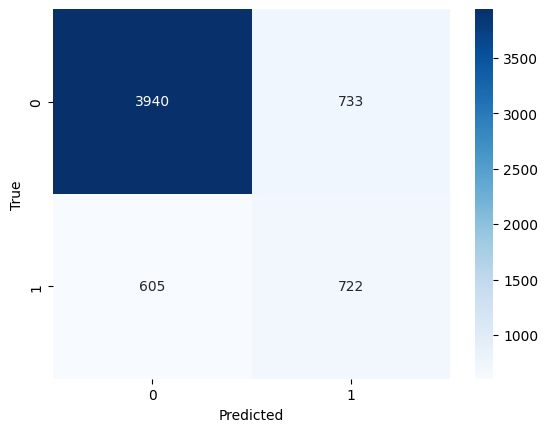

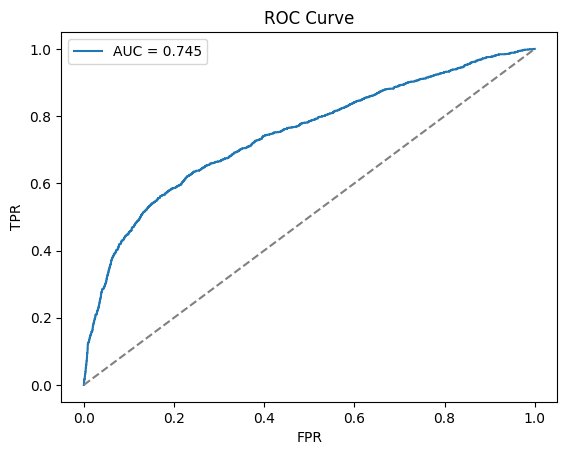

In [8]:
# ===========================
# Logistic Regression 
# ===========================
log_reg = Pipeline([
    ("scaler", scaler),
    ('smt', SMOTETomek(random_state=RS)),
    ("clf", LogisticRegression(penalty='l2', max_iter=1000, solver="liblinear"))
])

param_grid= {'clf__class_weight': [ {0:0.5, 1:0.5}, {0: 0.4, 1: 0.6}, {0: 0.3, 1: 0.7}, {0: 0.2, 1: 0.8}],
             'clf__C': np.logspace(-4,0,5)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

grid_lr = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid, 
    cv=skf, 
    scoring="roc_auc", 
    n_jobs=7,
    verbose=1)


print("Best params (LogReg):", grid_lr.best_params_)
evaluate_model(grid_lr.best_estimator_, X_test, y_test)

Best params (XGB_smotetomek_RS): {'clf__subsample': 1.0, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.01}
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.57      0.53      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000

ROC-AUC: 0.7640036696886715
F1: 0.5265005265005265
Accuracy: 0.7751666666666667


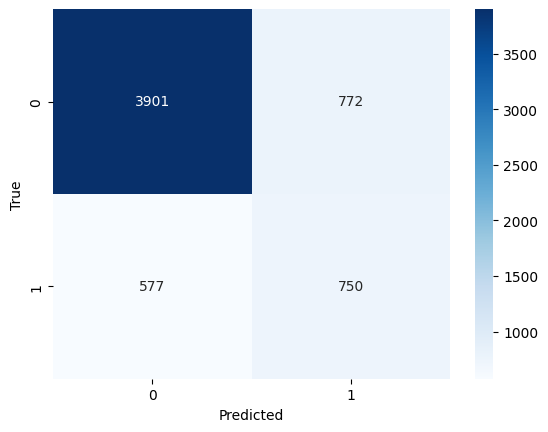

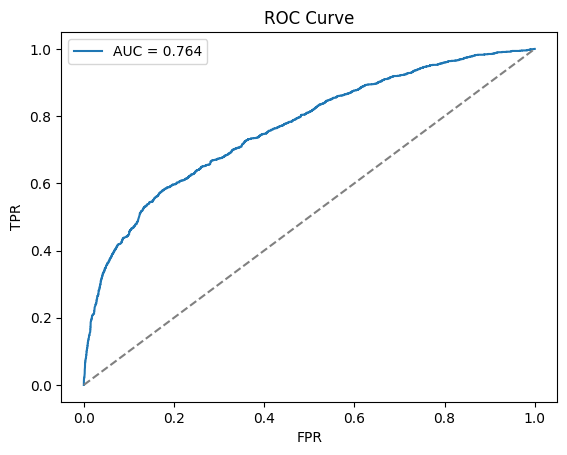

In [9]:
# ===========================
# XGBoost-SMOTETomek Classifier (RandomizedSearchCV)
# ===========================
xgb = Pipeline([
    ("scaler", scaler),
    ('smt', SMOTETomek(random_state=RS)),
    ("clf", XGBClassifier(objective='binary:logistic', eval_metric="logloss", random_state=RS))
])

param_dist = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [ 3, 4, 5],
    "clf__learning_rate": np.logspace(-4,-1,4),
    "clf__subsample": [0.7, 0.8, 1.0]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

random_xgb = RandomizedSearchCV(
    xgb, 
    param_dist, 
    n_iter=10, 
    cv=skf,
    scoring="roc_auc", 
    random_state=RS,
    n_jobs=7
)

random_xgb.fit(X_train, y_train)

print("Best params (XGB_smotetomek_RS):", random_xgb.best_params_)
evaluate_model(random_xgb.best_estimator_, X_test, y_test)

Best params (XGB Grid): {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4673
           1       0.50      0.55      0.53      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000

ROC-AUC: 0.7661390266294323
F1: 0.5258620689655172
Accuracy: 0.78


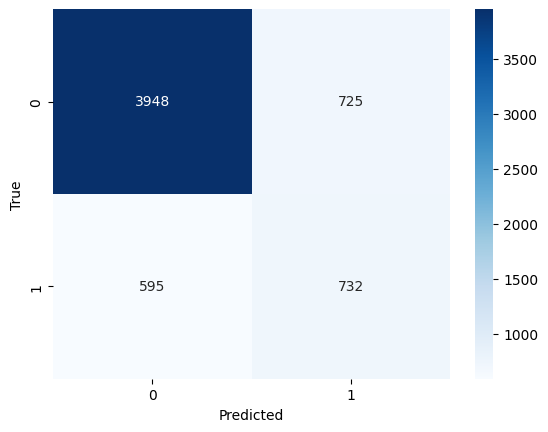

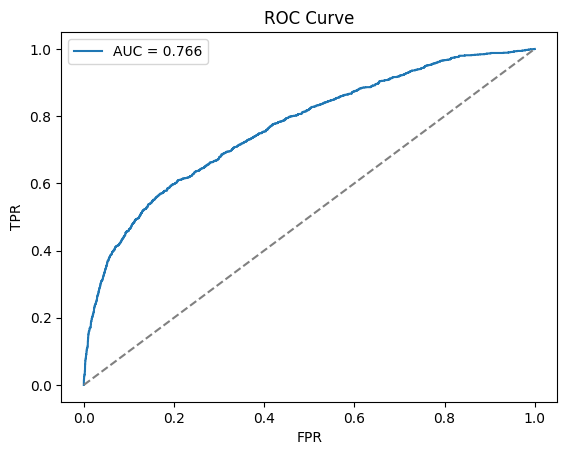

In [10]:
# ===========================
#  Grid Search for XGBoost
# ===========================
param_grid_xgb = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 4, 5],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1.0]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

grid_xgb = GridSearchCV(
    xgb, 
    param_grid_xgb, 
    cv=3,
    scoring="roc_auc", 
    n_jobs=7
)
grid_xgb.fit(X_train, y_train)

print("Best params (XGB Grid):", grid_xgb.best_params_)
evaluate_model(grid_xgb.best_estimator_, X_test, y_test)

In [16]:
results = pd.DataFrame([
    {
        "Model": "Logistic Regression+SMOTETomek (GridSearch)",
        "Accuracy": 0.777,
        "F1": 0.519,
        "ROC-AUC": 0.745,
        "Precision": 0.50,
        "Recall": 0.54
    },
    {
        "Model": "XGBoost +SMOTETomek (RandomSearch)",
        "Accuracy": 0.775,
        "F1": 0.527,
        "ROC-AUC": 0.764,
        "Precision": 0.49,
        "Recall": 0.57
    },
    {
        "Model": "XGBoost (GridSearch)",
        "Accuracy": 0.780,
        "F1": 0.526,
        "ROC-AUC": 0.766,
        "Precision": 0.50,
        "Recall": 0.55
    }
])

results


,Model,Accuracy,F1,ROC-AUC,Precision,Recall
0,Logistic Regression+SMOTETomek (GridSearch),0.777,0.519,0.745,0.50,0.54
1,XGBoost +SMOTETomek (RandomSearch),0.775,0.527,0.764,0.49,0.57
2,XGBoost (GridSearch),0.780,0.526,0.766,0.50,0.55


In [24]:
save_model(grid_lr.best_estimator_, "logreg.pkl")
save_model(random_xgb.best_estimator_, "xgb_smotetomek.pkl")
save_model(grid_xgb.best_estimator_, "xgb_grid.pkl")

Model saved at ./../models/logreg.pkl
Model saved at ./../models/xgb_smotetomek.pkl
Model saved at ./../models/xgb_grid.pkl


In [13]:
#Conclutions

Los tres modelos tienen desempeños similares, con  F1 en torno a 0.52–0.53.

El Logistic Regression logra un ROC-AUC de 0.745, mientras que XGBoost alcanza valores ligeramente mejores (0.764–0.766).

XGBoost + SMOTETomek solo se optimizó con RandomSearchCV, se requiere de una exploración másc completa de hiperparámetros.

El F1 es relativamente bajo porque la clase positiva (default) es difícil de predecir y está desbalanceada, incluso después de aplicar técnicas de balanceo.

  ----

Logistic Regression es una opción sólida: es interpretable, permite explicar a reguladores y stakeholders qué variables impactan más en la probabilidad de default.

XGBoost ofrece una pequeña ganancia en poder predictivo (mejor AUC), lo que en un contexto bancario puede traducirse en menos clientes mal clasificados y, por lo tanto, reducción de riesgo financiero.

La diferencia en desempeño es modesta, por lo que la decisión dependerá del trade-off entre interpretabilidad y precisión.

Si el negocio prioriza transparencia regulatoria → Logistic Regression es preferible.

Si el negocio prioriza maximizar la detección de riesgo aunque se pierda interpretabilidad → XGBoost es la mejor elección.